In [43]:
from IPython import display
from pathlib import Path
import shutil
import yaml

display.clear_output()

# Load config
with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Prevent ultralytics from tracking activity
!yolo settings sync=False

import ultralytics
ultralytics.checks()

Ultralytics 8.4.14 🚀 Python-3.13.11 torch-2.10.0 CPU (Apple M3 Pro)
Setup complete ✅ (11 CPUs, 36.0 GB RAM, 282.4/460.4 GB disk)


In [44]:
from ultralytics import YOLO
from IPython.display import display, Image
from cleanvision import Imagelab
from tqdm import tqdm
import cv2

In [45]:
# Verify person_only dataset
person_only_path = Path(f"../{config['paths']['person_only']}")
person_image_count = len(list(person_only_path.glob('*.png')))
print(f"Total images in person_only: {person_image_count}")

Total images in person_only: 721


---
# Phase 3: Full-body Detection
Dataset requirement: "Full-body person crops only (No feet or hands are acceptable)"

## Method selection

### Method A: Bounding Box Check (using Geometry)
**Logic**: if a person is "cut off," their bounding box will touch the very edge of the image frame.
Check the $y_{min}$ (top) and $y_{max}$ (bottom) of the bounding box. If the top of the box is at pixel 0, the head is likely cut off. If the bottom is at the maximum image height, the feet are cut off.
- **Pros**: Fast, simple, no extra inference needed
- **Cons**: Unreliable with loose bboxes; hand/feet could be in frame but still reject valid images

Loose bbox example:
- Person's feet are visible in the image
- But bbox is loose (has padding)
- Bbox bottom touches image edge
- Method A will return: "Cut off!" (but WRONG - feet are actually visible)

### Method B: Pose Estimation
**Logic**: Detect actual body keypoints (nose, ankles). A full-body person must have:
- Nose visible (head is visible)
- Left ankle visible (left leg visible)
- Right ankle visible (right leg visible)
- **Pros**: Detects actual body parts, not bbox edges. more robust to bbox variations
- **Cons**: Slower (additional pose inference per image)

---

## Model Selection

For pose estimation, there are a few models:
- YOLOv8-Pose
- MediaPipe Pose
- HRNet (High-Resolution Network)  


### Model choice: YOLOv8-Pose
1. Already using YOLOv8 for person detection (Phase 2). YOLOv8-Pose uses the same framework, reducing integration complexity.

2. Trained on COCO dataset with proven keypoint detection accuracy. No custom training or hyperparameter tuning needed. (Pre-trained)

3. Fast inference (~50-100ms/image), suitable for production pipeline processing hundreds of images.

4.  Single threshold parameter (`keypoint_confidence > 0.5`) - Minimal tuning

5. Full-body validation only needs 3 keypoints (nose + 2 ankles). YOLOv8-Pose detects 17 keypoints → more than sufficient.

Alternatives considered but not tested:
- MediaPipe Pose: Comparable accuracy but different ecosystem (Google vs Ultralytics)
- HRNet: Higher accuracy but ~3-5x slower, overkill for binary full-body check

Decision rationale:<br>
- Model comparison would require labeled validation set + benchmarking effort. Given YOLOv8-Pose meets all requirements (speed, accuracy, ease of use), experimentation offers low ROI.

source: https://blog.roboflow.com/best-pose-estimation-models/


### Yolov8 model size options<br>

**Keypoint Threshold: 0.5**
- Standard threshold used in YOLOv8-Pose documentation and research papers
- Represents "medium-high confidence" - balances false positives vs false negatives
- Values below 0.3 would include noisy/uncertain detections
- Values above 0.7 would be too strict and reject valid full-body images
- 0.5 is the recommended default for production use

**Model Size: Nano vs Small**
- Phase 3 task is simpler than Phase 2: just check if 3 keypoints (nose, ankles) exist in pre-cropped person images
- **Note**: The dataset comes pre-cropped (original_raw already contains person crops). Phase 2 only filters images containing valid person detections.
- Nano model still detects all 17 COCO keypoints with high accuracy (only need 3)
- Speed advantage: Nano ~50ms/image vs Small ~80ms/image (564 images → saves ~17 seconds)
- Accuracy trade-off minimal: For binary full-body check on clean crops, nano's keypoint precision is sufficient
- Different from Phase 2: Detection requires finding people in complex scenes (harder), pose estimation runs on single-person crops (easier)

Decision: Nano provides sufficient accuracy for the simple full-body validation task while maintaining fast inference.

source: https://www.ikomia.ai/blog/yolov8-pose-advanced-estimation


---
## Define Full-Body Validation Function

In [46]:
def is_fullbody_person(img, pose_model, keypoint_threshold=0.5):
    """
    Check if person has full body visible using pose keypoints.
    
    Note: Assumes img is already a cropped person image (from Phase 2).
    The original dataset comes pre-cropped - Phase 2 only filters images containing persons.
    
    Args:
        img: Pre-cropped person image array (BGR)
        pose_model: YOLOv8-Pose model
        keypoint_threshold: confidence threshold for keypoints (default: 0.5)
    
    Returns:
        dict: {'is_fullbody': bool, 'keypoint_confidence': dict}
    """
    # Run pose detection on pre-cropped person image
    results = pose_model.predict(source=img, verbose=False)
    result = results[0]
    
    if not result.keypoints or len(result.keypoints) == 0:
        return {'is_fullbody': False, 'keypoint_confidence': {}}
    
    # Get keypoints for first person (should be our detected person)
    keypoints = result.keypoints[0]
    
    # COCO keypoint indices: 0=nose, 15=left_ankle, 16=right_ankle
    nose_conf = keypoints.conf[0, 0].item() if keypoints.conf is not None else 0
    left_ankle_conf = keypoints.conf[0, 15].item() if keypoints.conf is not None else 0
    right_ankle_conf = keypoints.conf[0, 16].item() if keypoints.conf is not None else 0
    
    # Full-body: must have nose + both ankles with high confidence
    is_fullbody = (
        nose_conf > keypoint_threshold and 
        left_ankle_conf > keypoint_threshold and 
        right_ankle_conf > keypoint_threshold
    )
    
    return {
        'is_fullbody': is_fullbody,
        'keypoint_confidence': {
            'nose': float(nose_conf),
            'left_ankle': float(left_ankle_conf),
            'right_ankle': float(right_ankle_conf),

        }    }

## Load Pose Model

In [47]:
# Load pose model and config settings
pose_model_path = Path(config['models']['pose'])
keypoint_threshold = config['pose']['keypoint_threshold']
pose_model = YOLO(f"../{pose_model_path}")

print(f"Loaded pose model: {pose_model_path}")
print(f"Keypoint threshold: {keypoint_threshold}")

Loaded pose model: model/yolov8n-pose.pt
Keypoint threshold: 0.5


## Load Person Images from Phase 2

In [48]:
# Load person detection results from Phase 2
person_output_path = Path(f"../{config['paths']['person_only']}")
person_image_names = sorted([f.name for f in person_output_path.glob('*.png')])

print(f"Found {len(person_image_names)} person images to validate")
print(f"Sample: {person_image_names[:3]}")

Found 721 person images to validate
Sample: ['crop (1).png', 'crop (100).png', 'crop (1000).png']


## Run Full-Body Validation

In [49]:
# Run full-body detection on all person images
all_results = {}

for img_name in tqdm(person_image_names, desc="Validating full-body"):
    img_path = person_output_path / img_name
    img = cv2.imread(str(img_path))
    
    if img is None:
        continue
    
    # Run pose detection on pre-cropped person image
    result = is_fullbody_person(img, pose_model, keypoint_threshold)
    
    all_results[img_name] = {
        'is_fullbody': result['is_fullbody'],
        'keypoint_confidence': result['keypoint_confidence']
    }

# Summary stats
fullbody_count = sum(1 for r in all_results.values() if r['is_fullbody'])
total_count = len(all_results)
coverage = (fullbody_count / total_count * 100) if total_count > 0 else 0

print(f"\n{'='*50}")
print(f"Full-body validation results:")
print(f"  Full-body images: {fullbody_count}/{total_count} ({coverage:.1f}%)")
print(f"  Rejected (not full-body): {total_count - fullbody_count}")
print(f"{'='*50}")

Validating full-body: 100%|██████████| 721/721 [00:18<00:00, 39.49it/s]


Full-body validation results:
  Full-body images: 147/721 (20.4%)
  Rejected (not full-body): 574


In [50]:
# Save validated full-body images for Phase 4 (face validation)
validated_path = Path(f"../{config['paths']['validated']}")
if validated_path.exists():
    shutil.rmtree(validated_path)
validated_path.mkdir(exist_ok=True)

saved_count = 0
for img_name, result in all_results.items():
    if result['is_fullbody']:
        source_path = person_output_path / img_name
        shutil.copy(source_path, validated_path / img_name)
        saved_count += 1

print(f"\n{'='*50}")
print(f"Saved {saved_count} full-body validated images to: {config['paths']['validated']}")
print(f"{'='*50}")



Saved 147 full-body validated images to: data/validated


In [51]:
# Verify validated dataset
validated_path = Path(f"../{config['paths']['validated']}")
image_count = len(list(validated_path.glob('*.png')))
print(f"Total images in validated: {image_count}")


Total images in validated: 147


## Visualize full-body pose detection

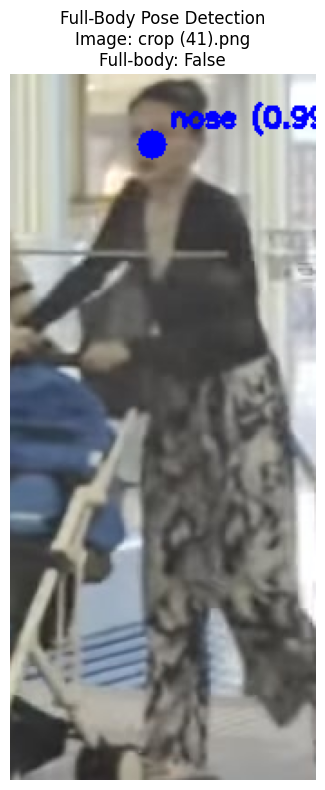

In [52]:
import matplotlib.pyplot as plt

# Change this to visualize a different image
test_image_name = 'crop (41).png'

# Load selected image
if test_image_name in all_results:
    test_img_path = person_output_path / test_image_name
    test_img = cv2.imread(str(test_img_path)).copy()
    test_result = all_results[test_image_name]
    
    # Run pose detection to get keypoints
    results = pose_model.predict(source=test_img, verbose=False)
    result = results[0]
    
    if result.keypoints and len(result.keypoints) > 0:
        keypoints = result.keypoints[0]
        kpts_xy = keypoints.xy[0].cpu().numpy()  # (17, 2) array of (x, y) coordinates
        kpts_conf = keypoints.conf[0].cpu().numpy()  # (17,) array of confidences
        
        # Draw keypoints (nose, ankles)
        keypoint_map = {
            0: ('nose', (255, 0, 0)),         # Red
            15: ('left_ankle', (0, 255, 0)),  # Green
            16: ('right_ankle', (0, 0, 255))  # Blue
        }
        
        for kpt_idx, (kpt_name, color) in keypoint_map.items():
            x, y = kpts_xy[kpt_idx]
            conf = kpts_conf[kpt_idx]
            
            if conf > keypoint_threshold:  # Only draw if detected
                cv2.circle(test_img, (int(x), int(y)), 8, color, -1)
                cv2.putText(test_img, f"{kpt_name} ({conf:.2f})", 
                           (int(x) + 10, int(y) - 10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        
        # Display result
        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Full-Body Pose Detection\nImage: {test_image_name}\nFull-body: {test_result['is_fullbody']}")
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("No keypoints detected!")
else:
    print(f"Image '{test_image_name}' not found in results.")
    print(f"Available images: {person_image_names[:10]}...")
